In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import requests
import os
import re
from string import digits
from google.colab import drive
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dense, Dropout, Softmax, Flatten, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.backend import clear_session
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:
drive.mount('/content/drive')

# Dataset Creation

The images for this dataset are scraped from Google Image Search. This scraping method is adapted from here: https://tinyurl.com/vn83kgp.

For each person included in the dataset, a Google Image Search query was carried and the following JavaScript commands used to save the urls of all the images appearing in the search results into a file:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));

window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

A file containing image urls was created for each of the considered individuals. The following block of codes reads, stores and displays the name of each of these files.

In [3]:
url_files = []
link_folder = '/content/drive/My Drive/EECE 693 Programming Midterm/Dataset/Link Files/'
# r=root, d=directories
for r, d, files in os.walk(link_folder):
    for file in files:
        url_files.append(os.path.join(file))

for url_file in url_files:
    print(url_file)

Tedros Adhanom
Fadlo Khuri
Hamad Hassan
Anthony Fauci
Marcel Ghanem
Bill Gates
Cate Blanchett
Donald Trump
Samuel L. Jackson
Keanu Reeves
Andrew M. Cuomo


Next, the following block of code will open each of these files one by one and extract the urls as a list. It will then iterate over these urls to download the corresponding images. Downloaded images are named after the person followed by an ordinality number.

At first, 80 images per person are downloaded. From these, 10 images per person will be manually selected for training and 2 for testing.
In case we were building a large dataset, manual selection would not be feasible. However, in this case the dataset is very small and therefore we cannot tolerate any outliers. For example, some of the images scraped had the subject's face partially blocked by other people or had a young image of the subject.

In [0]:
for url_file in url_files:
    image_path = '/content/drive/My Drive/EECE 693 Programming Midterm/Dataset/image_dump/'
    print(f'Downloading {url_file} images...\n')
    url_path = open(link_folder + url_file).read().strip().split('\n')
    total = 0

    if not os.path.exists(image_path):
        os.mkdir(image_path)
    image_path = image_path + url_file
    if not os.path.exists(image_path):
        os.mkdir(image_path)

    for url in url_path[:80]:
        try:
            req = requests.get(url, timeout=60)

            file_path = os.path.sep.join([image_path, '{}.jpg'.format(url_file + str(total+1))])
            file = open(file_path, 'wb')
            file.write(req.content)
            file.close()

            print('Downloaded {}'.format(file_path))
            total += 1

        except:
            print('Could not download {}. Downloading next file'.format(file_path))
    print('\n\n')

---

# Loading the Data

After having selected and partitioned the training and testing images into separate folders, the data is imported and processed.

Images are loaded, resized and normalized. They are stored in numpy arrays.

The label for each image is extracted from its name, the trailing digits and ".jpg" are removed. Labels are stored in a one-hot encoded format.

**Training and Validation Data**

In [0]:
image_list = []
label_list = []
train_folder = '/content/drive/My Drive/EECE 693 Programming Midterm/Dataset/Training/'
remove_digits = str.maketrans('', '', digits) 
for r, d, image_names in os.walk(train_folder):
    for image_name in image_names:
        img = load_img(train_folder + image_name, color_mode='rgb', target_size=(224,224))
        img = img_to_array(img)
        img = img / 255
        image_list.append(img)
        label_list.append(re.sub(r'.jpg', '', image_name).translate(remove_digits))
X_train = np.array(image_list)
y_train = pd.get_dummies(pd.DataFrame(label_list))
y_train.columns = [x[2:] for x in y_train.columns]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=11, random_state=42, shuffle=True, stratify=y_train)

**Testing Data**

In [0]:
image_list = []
label_list = []
test_folder = '/content/drive/My Drive/EECE 693 Programming Midterm/Dataset/Testing/'
remove_digits = str.maketrans('', '', digits) 
for r, d, image_names in os.walk(test_folder):
    for image_name in image_names:
        img = load_img(test_folder + image_name, color_mode='rgb', target_size=(224,224))
        img = img_to_array(img)
        img = img / 255
        image_list.append(img)
        label_list.append(re.sub(r'.jpg', '', image_name).translate(remove_digits))
X_test = np.array(image_list)
y_test = pd.get_dummies(pd.DataFrame(label_list))
y_test.columns = [x[2:] for x in y_test.columns]

**Prepare Image Augmentation**

In [0]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

---

# VGG-Face Model Transfer Learning

For accomplishing this task, the VGG-Face model will be fine-tuned on the presented dataset. VGG-Face is a VGG16-based network trained by Parkhi et al. (https://tinyurl.com/q32eqa8) on a large facial recognition dataset.

First, the VGG-Face model is created according to the architecture used by Parkhi et al. (https://tinyurl.com/s3un98p). Then, the pre-trained weights are loaded into it (the weights shared by Parkhi et al. are made compatible with Keras by Sefik Serengil https://tinyurl.com/trjp3rs).

The model for this task will incorporate the VGG-Face but with the last softmax layer removed. Two fully connected layers and a softmax layer with 11 outputs will be added. Only these new layers will be trained, all previous layers are frozen.

In [0]:
clear_session()
#Build the original VGG-Face
vgg_face = Sequential(name='vgg_face_original')
vgg_face.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
vgg_face.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(64, (3, 3), activation='relu'))
vgg_face.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(128, (3, 3), activation='relu'))
vgg_face.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(256, (3, 3), activation='relu'))
vgg_face.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(ZeroPadding2D((1,1)))
vgg_face.add(Convolution2D(512, (3, 3), activation='relu'))
vgg_face.add(MaxPooling2D((2,2), strides=(2,2)))
 
vgg_face.add(Convolution2D(4096, (7, 7), activation='relu'))
vgg_face.add(Dropout(0.5))
vgg_face.add(Convolution2D(4096, (1, 1), activation='relu'))
vgg_face.add(Dropout(0.5))
vgg_face.add(Convolution2D(2622, (1, 1)))
vgg_face.add(Flatten())
vgg_face.add(Activation('softmax'))

#Load Pre-trained Weights
vgg_face.load_weights('/content/drive/My Drive/EECE 693 Programming Midterm/vgg_face_weights.h5')

#Remove the Last Softmax Layer
vgg_base = Model(inputs=vgg_face.layers[0].input, outputs=vgg_face.layers[-2].output, name='vgg_base')

#Freeze Base Layers
for layer in vgg_base.layers:
    layer.trainable = False

#Add Fully Connected Layers
fc = Dense(1024, activation='relu')(vgg_base.layers[-1].output)
drp = Dropout(0.5)(fc)
fc_out = Dense(y_train.shape[1], activation='softmax')(drp)

model = Model(inputs=vgg_base.input, outputs=fc_out, name='final_model')

In [0]:
model.summary()

Model: "final_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      

In [0]:
#Check Layers Freezing Status
for layer in model.layers:
    if layer.trainable:
        print(layer.name + ' is trainable')

dense is trainable
dropout_2 is trainable
dense_1 is trainable


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/My Drive/EECE 693 Programming Midterm/final_model.hdf5', monitor='loss', save_best_only=True,)

bt = 10 #batch size
ep = 25 #number of epochs

history = model.fit(datagen.flow(X_train, y_train.values, batch_size=bt), steps_per_epoch=len(X_train)//bt,
                    validation_data=(X_val, y_val.values),
                    epochs=ep, callbacks=[checkpoint])

Epoch 1/25
9/9 [==============================] - 5s 560ms/step - loss: 2.3966 - accuracy: 0.1556 - val_loss: 2.2923 - val_accuracy: 0.4545
Epoch 2/25
9/9 [==============================] - 13s 1s/step - loss: 2.2727 - accuracy: 0.3034 - val_loss: 2.1675 - val_accuracy: 0.3636
Epoch 3/25
9/9 [==============================] - 16s 2s/step - loss: 2.0824 - accuracy: 0.4719 - val_loss: 2.0431 - val_accuracy: 0.4545
Epoch 4/25
9/9 [==============================] - 19s 2s/step - loss: 1.9679 - accuracy: 0.4607 - val_loss: 1.9293 - val_accuracy: 0.4545
Epoch 5/25
9/9 [==============================] - 10s 1s/step - loss: 1.8335 - accuracy: 0.5056 - val_loss: 1.8352 - val_accuracy: 0.6364
Epoch 6/25
9/9 [==============================] - 16s 2s/step - loss: 1.6652 - accuracy: 0.6404 - val_loss: 1.7428 - val_accuracy: 0.5455
Epoch 7/25
9/9 [==============================] - 16s 2s/step - loss: 1.6186 - accuracy: 0.6067 - val_loss: 1.6683 - val_accuracy: 0.5455
Epoch 8/25
9/9 [================

**Learning Curves**

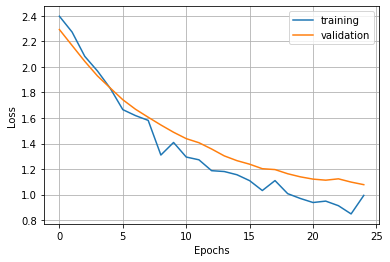

In [0]:
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [0]:
model.save_weights('/content/drive/My Drive/EECE 693 Programming Midterm/model_weights.h5', save_format='h5')

---

# Model Evaluation

In [0]:
model = load_model('/content/drive/My Drive/EECE 693 Programming Midterm/final_model.hdf5')

**On Training Data**

In [0]:
column_names = y_train.columns
X_train = np.vstack((X_train, X_val))
y_train = np.vstack((y_train, y_val))

In [6]:
model.evaluate(X_train, y_train, batch_size=1)

110/110 [==============================] - 7s 65ms/step - loss: 0.8040 - accuracy: 0.8364


[0.8040437698364258, 0.8363636136054993]

In [0]:
y_pred = model.predict(X_train, batch_size=1)
y_pred = list(np.argmax(y_pred, axis=1))
y_true = list(np.argmax(y_train, axis=1))

for i in range(len(y_pred)):
    y_pred[i] = column_names[y_pred[i]]
    y_true[i] = column_names[y_true[i]]

In [8]:
print(pd.DataFrame({'True Class': y_true, 'Predicted Class': y_pred}))

            True Class    Predicted Class
0           Bill Gates         Bill Gates
1         Donald Trump       Donald Trump
2        Marcel Ghanem      Marcel Ghanem
3    Samuel L. Jackson  Samuel L. Jackson
4       Cate Blanchett     Cate Blanchett
..                 ...                ...
105        Fadlo Khuri        Fadlo Khuri
106         Bill Gates        Fadlo Khuri
107       Keanu Reeves       Keanu Reeves
108      Anthony Fauci      Anthony Fauci
109     Tedros Adhanom     Tedros Adhanom

[110 rows x 2 columns]


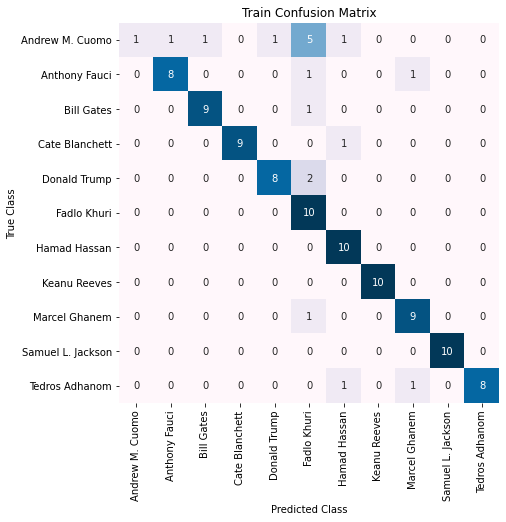

In [9]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred, labels=column_names), column_names, column_names)
plt.figure(figsize=(7,7))
sn.heatmap(df_cm, annot=True, cmap='PuBu', cbar=False, square=True)
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

**On Test Data**

In [10]:
model.evaluate(X_test, y_test, batch_size=1)

22/22 [==============================] - 1s 64ms/step - loss: 0.7912 - accuracy: 0.7727


[0.791175127029419, 0.7727272510528564]

In [0]:
y_pred = model.predict(X_test, batch_size=1)
y_pred = list(np.argmax(y_pred, axis=1))
y_true = list(np.argmax(y_test.values, axis=1))

In [0]:
for i in range(len(y_pred)):
    y_pred[i] = column_names[y_pred[i]]
    y_true[i] = column_names[y_true[i]]

In [13]:
print(pd.DataFrame({'True Class': y_true, 'Predicted Class': y_pred}))

           True Class    Predicted Class
0      Tedros Adhanom     Tedros Adhanom
1      Tedros Adhanom     Tedros Adhanom
2         Fadlo Khuri       Hamad Hassan
3         Fadlo Khuri      Marcel Ghanem
4        Hamad Hassan       Hamad Hassan
5        Hamad Hassan       Hamad Hassan
6       Anthony Fauci      Anthony Fauci
7       Anthony Fauci      Anthony Fauci
8       Marcel Ghanem      Marcel Ghanem
9       Marcel Ghanem      Marcel Ghanem
10         Bill Gates         Bill Gates
11         Bill Gates         Bill Gates
12     Cate Blanchett     Cate Blanchett
13     Cate Blanchett     Cate Blanchett
14       Donald Trump       Donald Trump
15       Donald Trump       Donald Trump
16  Samuel L. Jackson  Samuel L. Jackson
17  Samuel L. Jackson  Samuel L. Jackson
18       Keanu Reeves        Fadlo Khuri
19       Keanu Reeves       Keanu Reeves
20    Andrew M. Cuomo        Fadlo Khuri
21    Andrew M. Cuomo        Fadlo Khuri


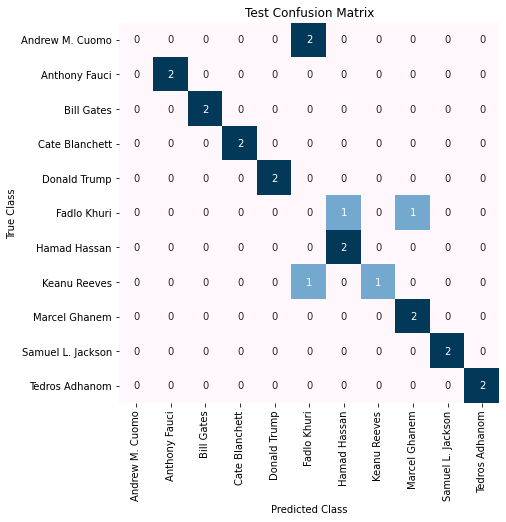

In [14]:
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred, labels=column_names), column_names, column_names)
plt.figure(figsize=(7,7))
sn.heatmap(df_cm, annot=True, cmap='PuBu', cbar=False, square=True)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()